<a href="https://colab.research.google.com/github/Xabz/Loss-functions-in-Siamese-network/blob/main/Constractive_loss_vs_Autoembedder_vs_Triplet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import os
import glob
import pickle
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.applications import *

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,calinski_harabasz_score,davies_bouldin_score,silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE


from PIL import Image, ImageDraw, ImageFont, ImageEnhance


!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

!pip3 install tf-models-official
import tensorflow_models as tfm

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
!nvidia-smi -L

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=75fdff3c71775dcda4ea3d2b657673863d24c75651f0ee34cc89b2512417d81a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
/bin/bash: line 1: nvidia-smi: command not found


Parameters

In [ ]:

top_model='MobileNet' #@param ['MobileNet','MobileNetV2','ResNet50','ResNet50V2','DenseNet121','EfficientNetB0','EfficientNetV2B0']
dataset = 'cifar10' #@param ['mnist', 'cifar10', 'fashion_mnist', 'emnist', 'cifar100']
loss = 'Cosine' #@param ['Autoembedder','Contrastive','Triplet','Cosine']

dist = -1 #contrastive->1 // autoembedder-> 100 // consine = -1


num_samples_train = 6000 #@param {type: 'integer'}
num_samples_val =  num_samples_train + int((20*num_samples_train)/60)
num_samples_test = num_samples_val + int((20*num_samples_train)/60)
dims=16 #@param {type: 'integer'}
batch_size=128 #@param {type: 'integer'}
epochs=250 #@param {type: 'integer'}

per_epoch_save=5 #@param {type: 'integer'}

base_dir = '/content/drive/MyDrive/Research_Result/contrastive_vs_autoembedder_vs_triplet'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)


##Data import

In [ ]:
(x_train, y_train), (x_test, y_test) = tfds.as_numpy(tfds.load(
    dataset,
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))
X = np.asarray(np.concatenate((x_train,x_test)),dtype=np.uint8)
y = np.asarray(np.concatenate((y_train,y_test)),dtype=np.uint8)
print(X.shape,y.shape)

x_train, y_train  = X[:num_samples_train], y[:num_samples_train]
x_val, y_val = X[num_samples_train:num_samples_val], y[num_samples_train:num_samples_val]
x_test, y_test = X[num_samples_val:num_samples_test], y[num_samples_val:num_samples_test]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(60000, 32, 32, 3) (60000,)
(6000, 32, 32, 3) (6000,)
(2000, 32, 32, 3) (2000,)
(2000, 32, 32, 3) (2000,)


##Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size,dist,input_shape,prob,loss):
        self.X = X                    #input data
        self.y = y                    #input labels
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.total       = len(X)
        self.dist       = dist         #Distance constraints(Hyperparameter)

        self.class_index = dict([(label, list(np.where(self.y == label)[0])) \
                                 for label in np.unique(self.y)])  #a dictionary contains indexes of similar class
        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size
        self.classes = len(np.unique(self.y))
        self.prob = prob
        self.loss = loss

        self.rand = random.Random(12)
        random.seed(12)

        self.on_epoch_end()


    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


    def __len__(self):
        return int(self.total // self.batch_size)

    def _make_choice(self, p=None):
        w = [0.5, 0.5]
        if p is not None:
            w = [p, 1-p]
        return self.rand.choices([True, False], weights=w)[0]


    def __getitem__(self, index):
        indexes1 = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        indexes2 = np.zeros(self.batch_size, dtype=np.uint8)
        constraint = np.zeros(self.batch_size, dtype=np.uint8)
        if self.loss == 'Cosine':
            constraint = np.ones(self.batch_size, dtype=np.uint8)


        if self.loss == 'Triplet':
            return self.X[indexes1], self.y[indexes1]

        for i in range(self.batch_size):
            label = self.y[indexes1[i]]
            if random.choices([True, False], weights=[0.5, 0.5])[0] == True:
                indexes2[i] = random.choice(self.class_index[label])
            else:
                choice = label
                while label == choice:
                    label = random.randint(0, self.classes-1)
                indexes2[i] = random.choice(self.class_index[label])
                constraint[i] = self.dist

        return [self.X[indexes1], self.X[indexes2]], constraint




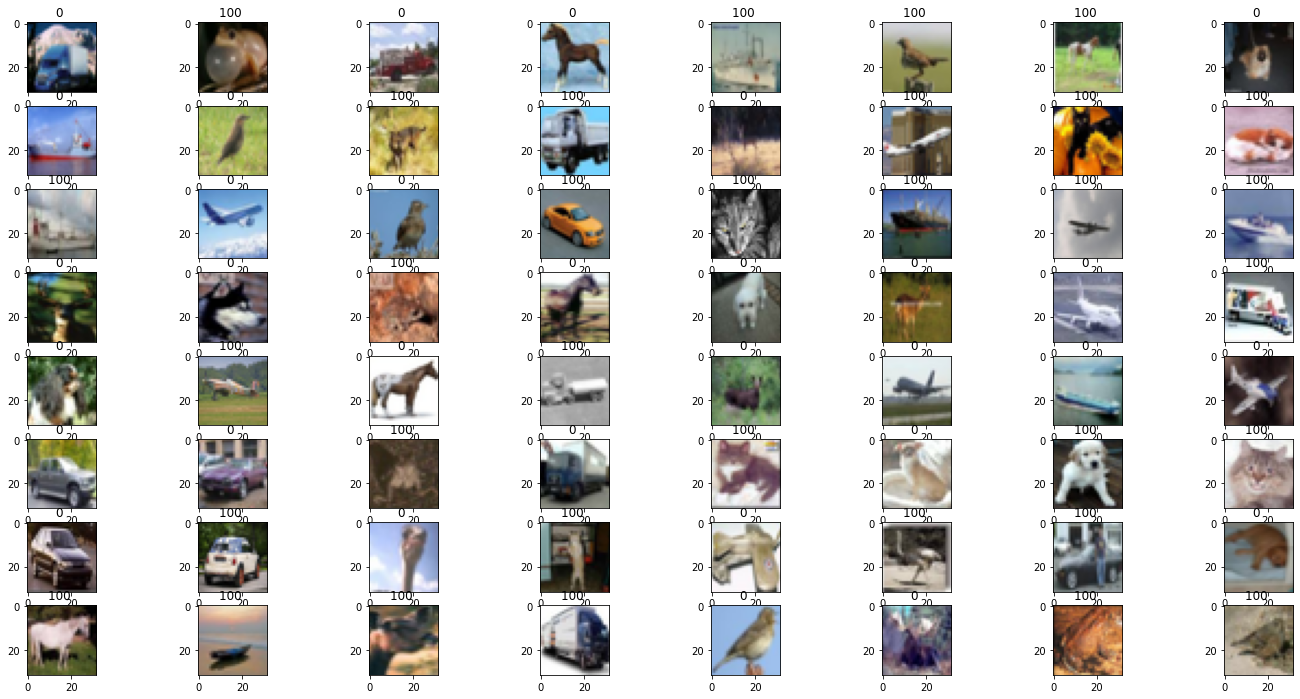

In [ ]:
dg = DataGenerator(X=x_train, y=y_train, batch_size=128,
                    dist=dist, input_shape=(32,32, 3),
                    prob=0.0,loss=loss)

xx,yy = dg[0]
_, ax = plt.subplots(8, 8, figsize=(24, 12))
for i in range(64):
    ax[i//8, i%8].imshow(xx[0][i, :, :,:])
    ax[i//8 ,i%8].set_title(f"{yy[i]} ", )

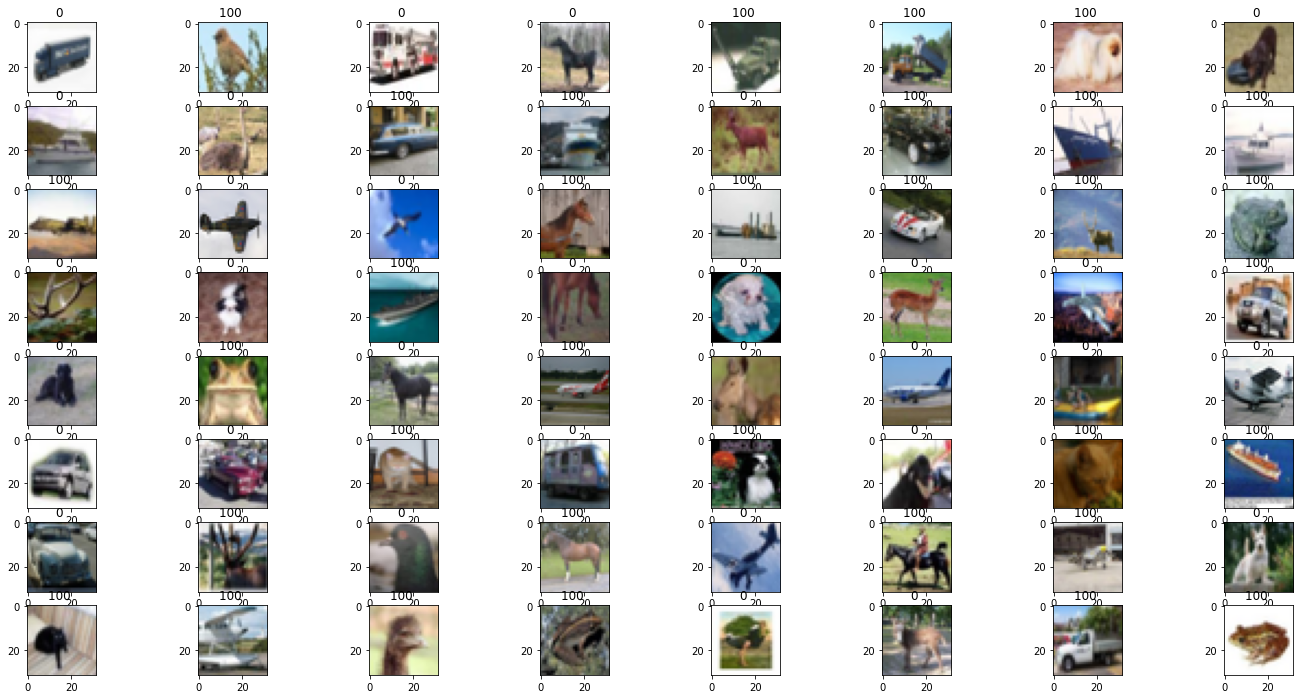

In [ ]:
_, ax = plt.subplots(8, 8, figsize=(24, 12))
for i in range(64):
    ax[i//8, i%8].imshow(xx[1][i, :, :,:], cmap="gray")
    ax[i//8 ,i%8].set_title(f"{yy[i]} " )

##Callback (Logger)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def accuracy(true_row_labels, predicted_row_labels):
    """Get the best accuracy.
    Parameters
    ----------
    true_row_labels: array-like
        The true row labels, given as external information
    predicted_row_labels: array-like
        The row labels predicted by the model
    Returns
    -------
    float
        Best value of accuracy
    """
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    rows, columns = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(rows, columns):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))


class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=None, validation_data=None,savepath=None,save_model=True,AE=None):
        self.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
            self.classes = len(np.unique(self.y_val))
        self.start_time = time.time()
        self.start_epoch = 0
        self.savepath=savepath
        self.save_model = save_model
        self.AE = AE
        self.savelog = {'Epoch': [], 'loss' : [],'NMI':[],'ACC':[],'ARI':[]}



    def on_train_begin(self,logs=None):
        if self.savepath != None:
            self.logpath = os.path.join(self.savepath, 'log.pickle')
            self.opti_path = os.path.join(self.savepath, 'optimizer.pkl')
            self.model_path = os.path.join(self.savepath, 'model_weights.h5')
        # Creating save paths
        if self.savepath != None and os.path.exists(self.savepath) == False:
            os.makedirs(self.savepath)
        # Loading previous data if found
        if self.savepath != None and os.path.exists(self.logpath):
            with open(self.logpath, 'rb') as f:
                self.savelog = pickle.load(f)
            print('Previous log loaded, starting epoch:', self.savelog['Epoch'][-1])
            self.start_epoch = self.savelog['Epoch'][-1]

    def on_epoch_end(self, epoch, logs={}):

        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return


        self.start_time = time.time()

        nmi, acc, ari = self._KmeansAcc(self.classes,self.y_val)

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: NMI {nmi:.5f} ACC {acc:.5f} ARI {ari:.5f} Time:{ep_time:.1f}",
              end='\n')


        self._saveLog(self.start_epoch, logs['loss'], nmi, acc, ari)

        if self.savepath != None:
            print(f'Saving model,, ')
            with open(self.logpath, 'wb') as f:
                pickle.dump(self.savelog, f)
            if self.save_model:
                self.model.save_weights(filepath=self.model_path, overwrite=True, )
                # self.model.optimizer.save_weights(self.opti_path,'optimizer_weights.pkl')
                # symbolic_weights = getattr(self.model.optimizer, 'weights')
                # weight_values = K.batch_get_value(symbolic_weights)
                weight_values = self.model.optimizer.get_weights()
                with open(self.opti_path, 'wb') as f:
                    pickle.dump(weight_values, f)
                # self.model.save_weights(self.model_path,overwrite=True)
                # self.model.optimizer.save_weights(self.opti_path,overwrite=True)



    def _saveLog(self, epoch, loss,nmi, acc, ari):
        self.savelog['Epoch'].append(epoch)
        self.savelog['loss'].append(loss)

        self.savelog['NMI'].append(nmi)
        self.savelog['ACC'].append(acc)
        self.savelog['ARI'].append(ari)



    def _KmeansAcc(self,classes,y_val):
        rindex = np.random.randint(0,y_val.shape[0],size=1000)
        kmeans = KMeans(n_clusters=classes, n_init=10)
        outs = self.AE.predict(self.x_val[rindex])
        y_pred = kmeans.fit_predict(outs)
        acc = accuracy(y_val[rindex], y_pred)
        nmi = normalized_mutual_info_score(y_val[rindex], y_pred)
        ari = adjusted_rand_score(y_val[rindex], y_pred)


        return (acc, nmi, ari)

#Custom losses and layers

In [ ]:
def Contrastive_loss(y, y_pred, margin=1):
    y = tf.cast(y, y_pred.dtype)
    squaredPreds = K.square(y_pred)
    squaredMargin = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss


In [ ]:
class CosineEmbeddingLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.0, **kwargs):
        super(CosineEmbeddingLoss, self).__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        cosine_similarity = tf.keras.losses.cosine_similarity(y_true, y_pred, axis=-1)
        positive_dists = cosine_similarity[tf.equal(y_true, 1)]
        negative_dists = cosine_similarity[tf.equal(y_true, -1)]
        losses = tf.maximum(0.0, self.margin - positive_dists + negative_dists)
        return tf.reduce_mean(losses)

In [ ]:
class Distance(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, inputs):
        dist = tf.expand_dims(tf.math.sqrt(tf.math.reduce_sum(tf.math.square(inputs[0]-inputs[1]),
                                                              axis=1)),
                              axis=-1)
        return dist




#Architecture

In [ ]:

def buildAE(input_shape, dims, dist=1, topmodel = 'MobileNet',loss= None):

    inp1 = tf.keras.Input(input_shape, name='input1')
    input1 = tf.keras.layers.Lambda(lambda x: (x/255.0))(inp1)
    inp2 = tf.keras.Input(input_shape, name='input2')
    input2 = tf.keras.layers.Lambda(lambda x: (x/255.0))(inp2)


    topmodel = eval(f"{topmodel}(input_shape={input_shape}," +
                        "include_top=False, weights='imagenet')")

    m = tf.keras.Sequential([topmodel,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(dims)],
                            name='AutoEmbedder')

    out1 = m(input1)
    out2 = m(input2)


    # Initializing model


    #Autoembedder
    if loss == 'Autoembedder':
        out = Distance()([out1, out2])
        out = tf.keras.layers.ReLU(max_value=dist)(out)
        model = tf.keras.Model([inp1, inp2], out, name="Pairwise_Architecture")
        model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                      loss='mse')

    #contrastive
    elif loss == 'Contrastive':
        out = Distance()([out1, out2])
        out = tf.keras.layers.BatchNormalization()(out)
        out = tf.keras.layers.Dense(1,activation='sigmoid')(out)
        model = tf.keras.Model([inp1, inp2], out, name="Pairwise_Architecture")
        model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                      loss=Contrastive_loss)

    #triplet
    elif loss == 'Triplet':
        out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(out1)
        model = tf.keras.Model(inp1, out1, name="triplet_Architecture")
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                      loss=tfa.losses.TripletSemiHardLoss())


    elif loss == 'Cosine':
    #     out = Distance()([out1,out2])
    #     out = tf.keras.layers.Activations('tanh')(out)
    #     model = tf.keras.Model([inp1, inp2], out, name="Pairwise_Architecture")
    #     model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    #                   loss=tf.keras.losses.CosineSimilarity())

        outs = [out1,out2]
        # Cosine similarity layer
        cosine_similarity = tf.keras.layers.Lambda(lambda x: tf.keras.losses.cosine_similarity(x[0],x[1]), name='cosine_similarity')(outs)

        # Model
        model = tf.keras.Model(inputs=[inp1, inp2], outputs=cosine_similarity)

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='MSE')  # Use MSE as an example

    AE = tf.keras.Model(inp1, out1, name="Embedder")

    return model, AE


#Training

In [ ]:
strat = tf.distribute.MirroredStrategy()
global AE
tf.keras.backend.clear_session()

nmodel = f"{top_model}" if top_model == 'MobileNet' else f"{top_model}"
pname = f"{nmodel}_D{dims}_{dataset}_{loss}_supervised"

loaded = False
save_dir = os.path.join(base_dir, pname)
opti_dir = os.path.join(save_dir,'optimizer.pkl')

dg = DataGenerator(X=x_train, y=y_train, batch_size=128, dist=dist,
                   input_shape=x_train.shape[1:],prob=0, loss=loss)


if os.path.exists(os.path.join(save_dir, 'model_weights.h5')):
    try:
        print('Previous weights found, building model')
        with strat.scope():
            model, AE = buildAE(x_train.shape[1:], dims=dims,
                                dist=dist, topmodel=top_model,loss=loss)
            print('Loading weights')
            model.load_weights(os.path.join(save_dir, 'model_weights.h5'))
        loaded = True
    except Exception as e:
        print(str(e))
        pass

    print('loading optimizer')
    grad_vars = model.trainable_weights
    zero_grads = [tf.zeros_like(w) for w in grad_vars]
    model.optimizer.apply_gradients(zip(zero_grads, grad_vars))
    with open(opti_dir, 'rb') as f:
      weight_values = pickle.load(f)
    model.optimizer.set_weights(weight_values)


if not loaded:
    print('Initializing new model')
    with strat.scope():
        model, AE = buildAE(x_train.shape[1:], dims=dims,
                            dist=dist, topmodel=top_model,loss=loss)
    loaded = True


log = MyLogger(per_epoch_save, validation_data=(x_test,y_test),savepath=save_dir,save_model=True, AE=AE)

print(pname)
model.summary()
model.get_layer('AutoEmbedder').summary()

flops = tfm.core.train_utils.try_count_flops(model)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

print('Starting model training')
model.fit(dg, epochs=epochs+1, verbose=1,callbacks=[log],)

Previous weights found, building model
Loading weights
loading optimizer
MobileNet_D16_cifar10_Cosine_supervised
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32, 32, 3)            0         ['input1[0][0]']              
                                                                                                  
 lambda_1 (Lambda)           (None, 32, 32, 3)            0         ['input2[0][

#Figures

In [ ]:
from scipy.signal import savgol_filter
def plotter(savelog,avg_val,epoch_limit=None):

        def moving_average(x, w):
            return savgol_filter(x, w, 1)

        if epoch_limit != None:
            end_idx = 0
            while end_idx < len(savelog["Epoch"]) and \
                  savelog["Epoch"][end_idx] <= epoch_limit:
                end_idx += 1

        for k in savelog.keys():
            if len(savelog[k]) > 0:
                savelog[k] = savelog[k][:end_idx]

        if avg_val > 1:
            for k in savelog.keys():
                if len(savelog[k]) > 0 and k != "Epoch" and k!='loss':
                    savelog[k] = moving_average(savelog[k], avg_val)


        #clear_output(wait=True)
        plt.figure(figsize=(12.9, 8.3))
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        # solid are the train data
        plt.plot(savelog['Epoch'], (savelog['ACC']),
                label='ACC', c='purple')
        plt.plot(savelog['Epoch'], (savelog['NMI']),
                label='NMI', c='orange')
        plt.plot(savelog['Epoch'], (savelog['ARI']),
                 label='ARI', c='c')
        #dashed is for val_loss
        # plt.plot(savelog['Epoch'], (savelog['loss']),
        #          '--', label='ARI', c='c')

        plt.ylabel('Score')
        plt.xlabel('Epoch')
        plt.ylim([0.0,1.0])
        plt.grid()
        plt.minorticks_on()
        plt.grid(b=True, which='minor', linestyle='--', alpha=0.25)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fontsize= 'large',
                   fancybox=True, shadow=False, ncol=4)

        # plt.savefig()


In [ ]:

base_dir = '/content/drive/MyDrive/Research_Result/contrastive_vs_autoembedder_vs_triplet'
# dic = f'/content/drive/MyDrive/Research_Result/contrastive_vs_autoembedder_vs_triplet/{top_model}_D{dims}_{dataset}_{loss}/log.pickle'
dic = '/content/drive/MyDrive/Research_Result/contrastive_vs_autoembedder_vs_triplet/DenseNet121_D16_cifar_10_Triplet/log.pickle'

print(dic)

# savelog = {'Epoch': [], 'loss' : [],
#            'K-means_PY_ACC':[], 'K-means_PY_NMI':[], 'K-means_PY_ARI':[], 'K-means_GY_ACC':[], 'K-means_GY_NMI':[], 'K-means_GY_ARI':[],
#            'EM_PY_ACC':[], 'EM_PY_NMI':[], 'EM_PY_ARI':[], 'EM_GY_ACC':[], 'EM_GY_NMI':[], 'EM_GY_ARI':[],}
savelog = {'Epoch': [], 'loss' : [],'NMI':[],'ACC':[],'ARI':[]}
savelog.clear()
with open(dic, 'rb') as f:
    savelog = pickle.load(f)
print(savelog['Epoch'][-1])

/content/drive/MyDrive/Research_Result/contrastive_vs_autoembedder_vs_triplet/DenseNet121_D16_cifar_10_Triplet/log.pickle
200


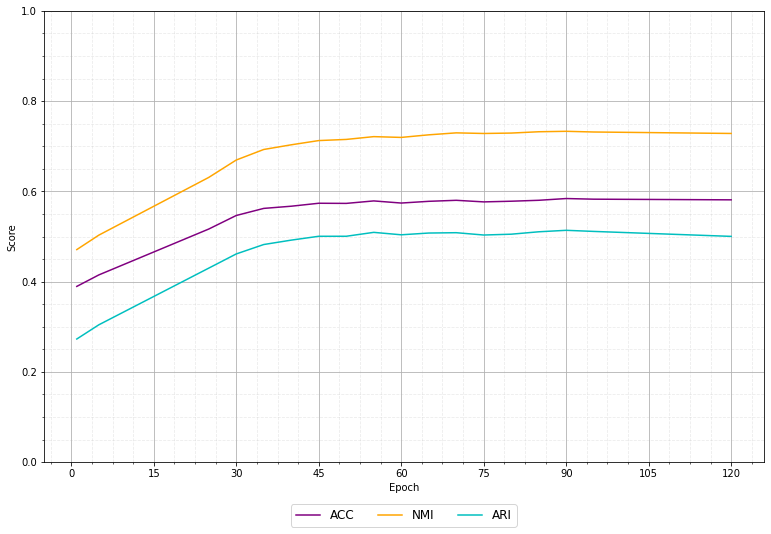

In [ ]:
plotter(savelog.copy(),11,120) #Autoembedder

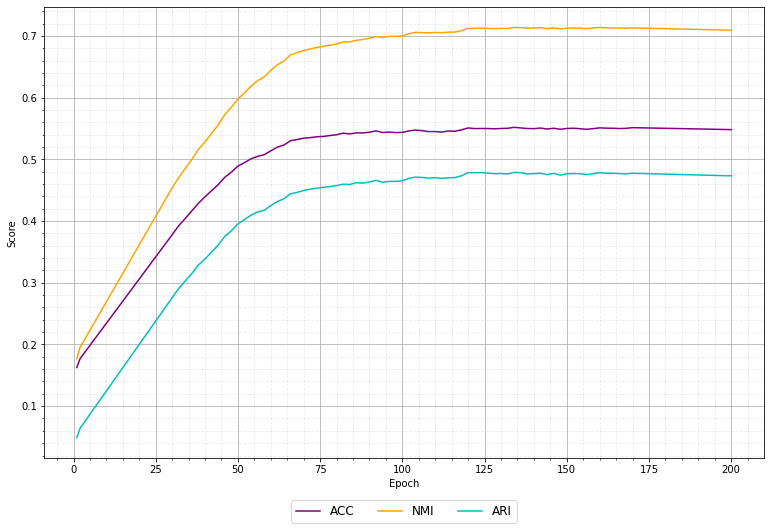

In [ ]:
plotter(savelog.copy(),31,200) #Autoembedder batchnormalization

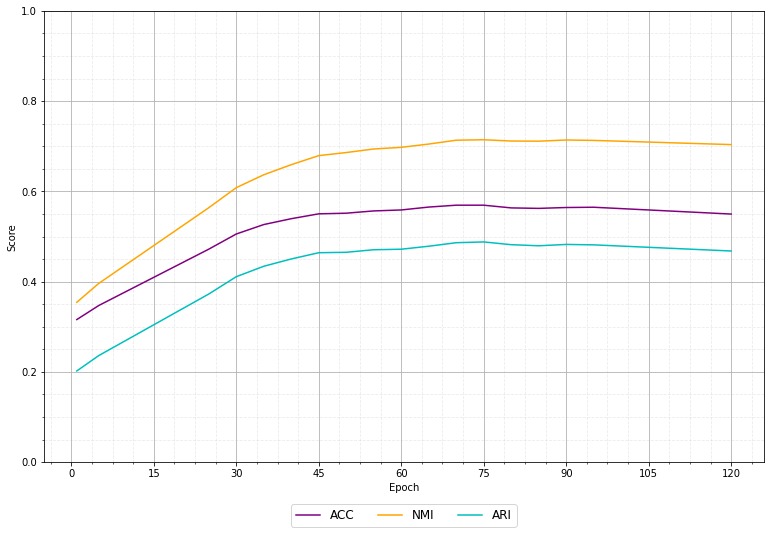

In [ ]:
plotter(savelog.copy(),11,120) #contrastive

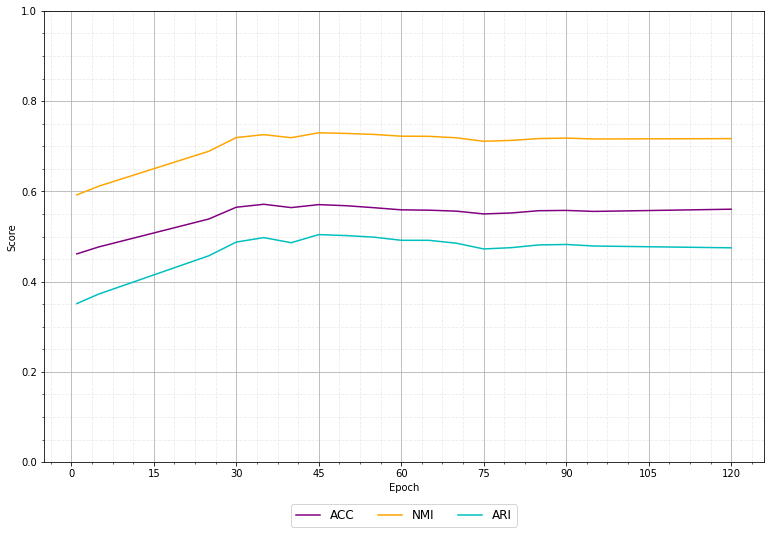

In [ ]:
plotter(savelog.copy(),11,120) #Triplet

In [ ]:
def plotImgMap(x, y, points,AE, imgsize=(40, 40), figsize=(15, 15), rand=12,
               imgplot=True, legend=False):
    def getImage(img):
        #img = ((img+1)/2)*255
        img = np.array(img, dtype=np.uint8)
        #print(type(img), img.shape, img.dtype)
        img = Image.fromarray(img)
        img = img.resize(imgsize)
        img = img.convert("RGBA")
        ImageDraw.floodfill(img, xy=(0, 0), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(imgsize[0], 0), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(0, imgsize[1]), value=(255, 255, 255, 0), thresh=100)
        ImageDraw.floodfill(img, xy=(imgsize[0], imgsize[1]), value=(255, 255, 255, 0), thresh=100)
        return OffsetImage(img)

    rnd = random.Random(rand)
    q = np.unique(rnd.sample(range(0, x.shape[0]), points))
    outs = AE(x[q, ...])
    labels = y[q, ...]

    X_embedded = TSNE(n_components=2, random_state=rand).fit_transform(outs)
    fig, ax = plt.subplots(figsize=figsize)

    #if not imgplot:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)

    if imgplot:
        for i, idx in enumerate(q):
            ab = AnnotationBbox(getImage(x[idx]), (X_embedded[i, 0], X_embedded[i, 1]),
                                frameon=False)
            ax.add_artist(ab)
            #c = plt.Circle((X_embedded[i, 0], X_embedded[i, 1]), 3, color='r',
            #               fill=False, clip_on=False)
            #ax.add_patch(c)

    ax.grid(False)
    ax.legend()
    plt.show()

plotImgMap(x_test, y_test, 500, AE=AE)